<a href="https://colab.research.google.com/github/denred0/simpsons_cnn/blob/main/simpsons_kaggle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 253kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
!pip install "wheel==0.34.2"

ERROR: tensorflow 2.4.1 has requirement wheel~=0.35, but you'll have wheel 0.34.2 which is incompatible.
  Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2


In [ ]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torch==1.7.1+{accelerator} torchvision==0.8.2+{accelerator} torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 12.8MB 241kB/s 
     |████████████████████████████████| 7.6MB 4.2MB/s 
  Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2


In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
#!pip uninstall imgaug
!pip install imgaug==0.2.5

     |████████████████████████████████| 563kB 9.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-cp36-none-any.whl size=561439 sha256=574140635f548c3772e1a2aff5c837dc3848bba8f7a383350964af4579cc62c6
  Stored in directory: /root/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae0b
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q /content/gdrive/My\ Drive/datasets/simpsons/data/simpsons_dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/datasets/simpsons/data/testset.zip -d test

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Feb  2 04:07:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from collections import Counter

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    # __init__ вызывается при создании экземляра класса
    def __init__(self, files, mode):
        # super().__init__() вызывает конструктор родительского класса, чтобы 
        # можно было использовать его унаследованные методы, например, _len
        super().__init__() 
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            # self.files[0] PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg')
            # path  train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg
            # path.parent  train/simpsons_dataset/abraham_grampa_simpson
            # path.parent.name  abraham_grampa_simpson
            # получаем список лейблов-названий папок
            self.labels = [path.parent.name for path in self.files]
            # возвращает объект LabelEncoder() у которого есть поле le.classes_
            # в котором сохранен массив наших меток классов
            self.label_encoder.fit_transform(self.labels)

            # сохраняем метки классов
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        # ресайзим изображение и переводим в np array
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        transform_aug = transforms.Compose([
            #transforms.ColorJitter(brightness=0.1 * torch.randn(1), contrast=0.1 * torch.randn(1), saturation=0.1 * torch.randn(1), hue=0.1 * torch.randn(1)),
            # transforms.ColorJitter(brightness = np.abs(0.1 * torch.randn(1).item()), contrast = np.abs(0.1 * torch.randn(1).item()), 
            #                        saturation = np.abs(0.1 * torch.randn(1).item())), #, hue = np.abs(0.1 * torch.randn(1).item())
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20) 
        ])
        
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
          x = transform_aug(x)
        # получаем массив 224х224х3, где 3 - это количество каналов. Каждое значение в этот массиве значение вида [124, 234, 166], которое показывает цвет конкретного пикселя
        x = self._prepare_sample(x)
        # потом делим на 255, чтобы привести к значениям от 0 до 1. 
        x = np.array(x / 255, dtype='float32')
        # нормализуем
        x = transform(x)
        if self.mode == 'test':
          return x
        else:
            label = self.labels[index]
            # возвращает индекс класса
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
np.abs(0.1 * torch.randn(1).item())

0.03609450161457062

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    # все, что меньше 0 становится = 0, что больше 1 становится равным 1
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_files[0]

PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg')

In [ ]:
for i, path in enumerate(train_val_files):
  if i == 0:
    print('path ', path)
    print('path.parent ', path.parent)
    print('path.parent.name ', path.parent.name)

path  train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg
path.parent  train/simpsons_dataset/abraham_grampa_simpson
path.parent.name  abraham_grampa_simpson


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_val_labels = [path.parent.name for path in train_val_files]
le.fit_transform(train_val_labels)
# label = le.classes_[1]
# label_id = le.transform([label])
# label_id.item()
# #le.transform(label)

array([ 0,  0,  0, ..., 41, 41, 41])

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.20, \
                                          stratify=train_val_labels)

In [ ]:
len(val_files)

4187

In [ ]:
image = Image.open(val_files[0])
image.load()
image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
x = np.array(image)
x = np.array(x / 255, dtype='float32')

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
transform(x).shape

torch.Size([3, 224, 224])

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

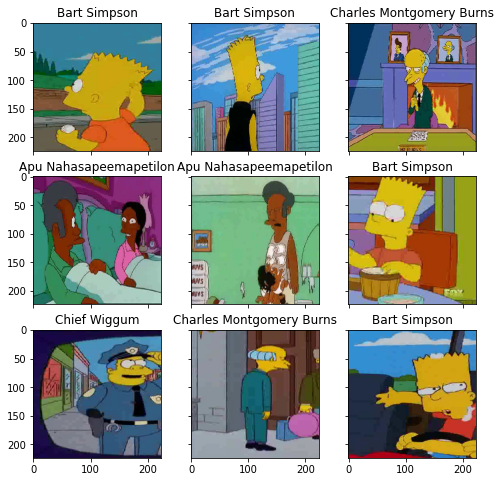

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    inp = im_val.numpy().transpose((1, 2, 0))
   # print(im_val[0])
   # print(inp[0])
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

### Построение нейросети

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size):

    # перевожу в словарь, чтобы получить количество экземпляров каждого класса
    # на выходе получаю {'homer_simpson' : 15, 'march_simpson' : 56, ...}
    a = dict(Counter(train_dataset.labels))
    # достаю только значения из словаря
    class_sample_counts = list(a.values())
    # получаю веса каждого класса, список длинной 42 равный количеству классов
    weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)

    # получаю айдишники для каждой метки класса т.к. работать со стороковыми ключами не получится 
    le = preprocessing.LabelEncoder()
    ids = le.fit_transform(train_dataset.labels)
    # получаю список весов для каждого экземпляра класса 
    samples_weights = weights[ids]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(
              weights=samples_weights,
              num_samples=len(samples_weights),
              replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #shuffle=True shuffle не работает с sampler
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()
       # scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.5) # уменьшение lr на каждой эпохе на 0.5

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

          #  scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# x = SimpsonsDataset(train_files, mode='train')
# from collections import Counter
# a = dict(Counter(x.labels))
# a
# class_sample_counts = list(a.values())
# class_sample_counts

In [ ]:
# weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
# weights

In [ ]:
# le = preprocessing.LabelEncoder()
# ids = le.fit_transform(x.labels)
# ids

In [ ]:
# samples_weights = weights[ids]

In [ ]:
# samples_weights

In [ ]:
# from torch.utils.data.sampler import WeightedRandomSampler

# sampler = torch.utils.data.sampler.WeightedRandomSampler(
#     weights=samples_weights,
#     num_samples=len(samples_weights),
#     replacement=True)

In [ ]:
# a.values()

In [ ]:
import torch
torch.manual_seed(42)

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.9681986544161562


epoch:  10%|█         | 1/10 [02:35<23:19, 155.55s/it]


Epoch 001 train_loss: 0.9682     val_loss 1.0263 train_acc 0.7327 val_acc 0.7258
loss 0.9285031697961659


epoch:  20%|██        | 2/10 [05:11<20:45, 155.66s/it]


Epoch 002 train_loss: 0.9285     val_loss 0.9626 train_acc 0.7414 val_acc 0.7261
loss 0.912753681711978


epoch:  30%|███       | 3/10 [07:47<18:10, 155.80s/it]


Epoch 003 train_loss: 0.9128     val_loss 1.0025 train_acc 0.7482 val_acc 0.7294
loss 0.9104523373863168


epoch:  40%|████      | 4/10 [10:23<15:35, 155.96s/it]


Epoch 004 train_loss: 0.9105     val_loss 1.0171 train_acc 0.7488 val_acc 0.7220
loss 0.9018999762351718


epoch:  50%|█████     | 5/10 [13:00<13:00, 156.04s/it]


Epoch 005 train_loss: 0.9019     val_loss 0.9503 train_acc 0.7510 val_acc 0.7449
loss 0.8842429831138182


epoch:  60%|██████    | 6/10 [15:36<10:24, 156.16s/it]


Epoch 006 train_loss: 0.8842     val_loss 0.9885 train_acc 0.7546 val_acc 0.7392
loss 0.8785206879265887


epoch:  70%|███████   | 7/10 [18:12<07:48, 156.15s/it]


Epoch 007 train_loss: 0.8785     val_loss 0.9413 train_acc 0.7564 val_acc 0.7454
loss 0.8772242987553136


epoch:  80%|████████  | 8/10 [20:48<05:12, 156.16s/it]


Epoch 008 train_loss: 0.8772     val_loss 0.8974 train_acc 0.7599 val_acc 0.7480
loss 0.8704289988094399


epoch:  90%|█████████ | 9/10 [23:26<02:36, 156.62s/it]


Epoch 009 train_loss: 0.8704     val_loss 0.9471 train_acc 0.7594 val_acc 0.7423
loss 0.8572266482045456


epoch: 100%|██████████| 10/10 [26:04<00:00, 156.43s/it]


Epoch 010 train_loss: 0.8572     val_loss 0.9012 train_acc 0.7631 val_acc 0.7569


In [ ]:
#history

In [ ]:
Epoch 010 train_loss: 0.7648     val_loss 0.8773 train_acc 0.7883 val_acc 0.7669 overfiting
Epoch 020 train_loss: 0.4558     val_loss 0.7478 train_acc 0.8707 val_acc 0.8177 
Epoch 030 train_loss: 0.3504     val_loss 0.7880 train_acc 0.8928 val_acc 0.8277
Epoch 025 train_loss: 0.4005     val_loss 0.7028 train_acc 0.8839 val_acc 0.8338

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
#loss

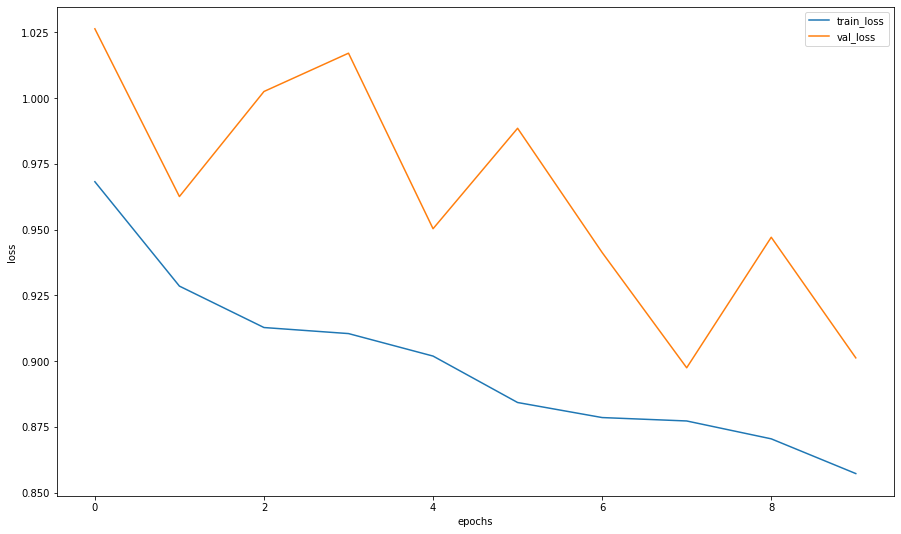

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

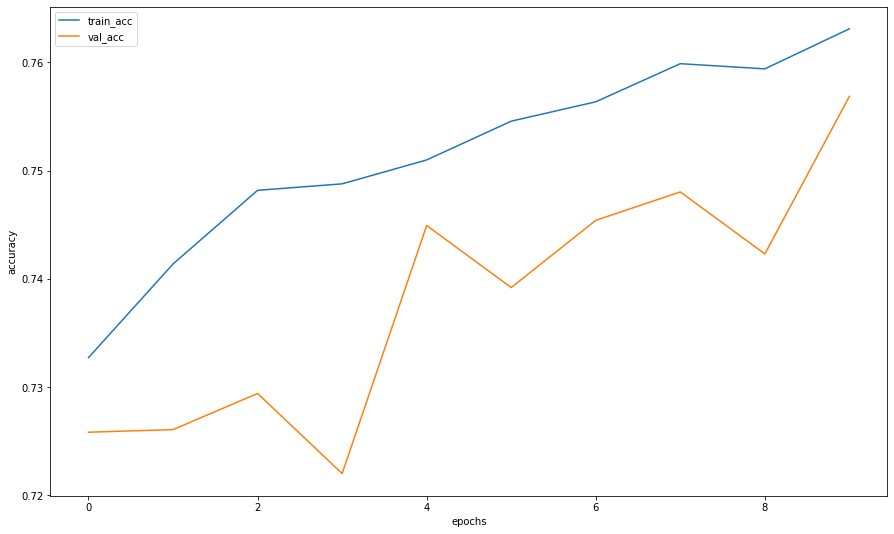

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]

# probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
#probs_im

In [ ]:
#idxs = list(map(int, np.random.uniform(0, 1000, 20)))
idxs = list(range(len(val_files)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
#label_encoder.inverse_transform([val_dataset[0][1]])[0] 

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.inverse_transform([val_dataset[id][1]])[0] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from collections import Counter
import pandas as pd
actual_c = Counter(actual_labels)
actual_pd = pd.DataFrame.from_dict(dict(actual_c), orient='index', columns=['count']).reset_index()
actual_pd = actual_pd.rename(columns={"index": "class"})

for cl in actual_pd['class']:
  aaa = [x if x==cl else 'none' for x in actual_labels]
  acc = 0
  for x, y in zip(aaa, preds_class):
    if x == y:
      acc+=1
  actual_pd.loc[actual_pd['class']  == cl, 'acc'] = acc/actual_pd['count']

actual_pd.to_csv('gdrive/My Drive/datasets/simpsons/data/val_result.csv', index=False)

In [ ]:
from sklearn.metrics import f1_score
#preds_class
f1_score(actual_labels, preds_class, average='micro')

0.8332935275853833

In [ ]:
0.7980512036683225 val not aug
0.7854413450515858 val also aug
0.7936568589988537 without aug
0.8332935275853833 

In [ ]:
 переобучени
 weight decay
 ауги
lr scheduller
batchnorm
size of batch
epoch count
не адам, а что-то другое
Подбирать начальный лр
Другая сеть
Нормализация картинки, что это 
не обрезать картинки

findfont: Font family ['roboto'] not found. Falling back to DejaVu Sans.


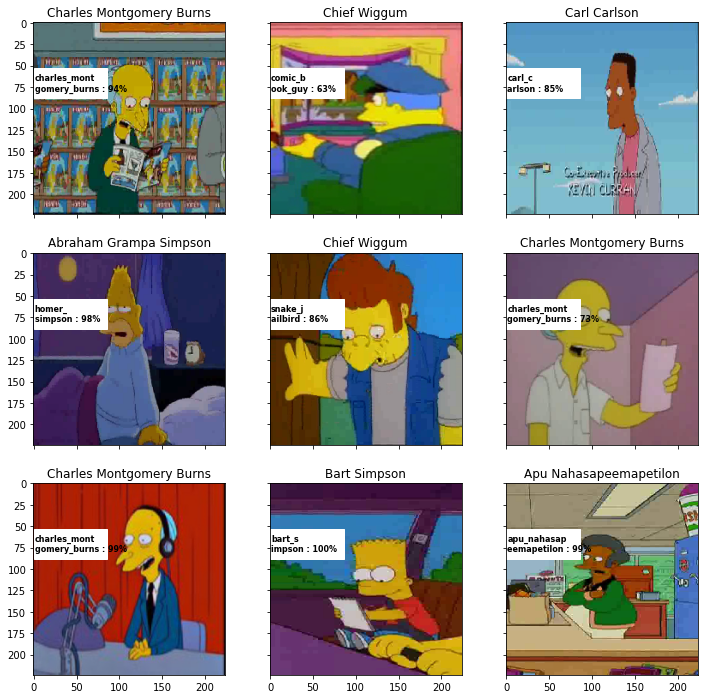

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("roboto")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

gdrive	label_encoder.pkl  sample_data	test  train


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/datasets/simpsons/data/2.txt")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('gdrive/My Drive/datasets/simpsons/data/simple_cnn_baseline3.csv', index=False)